<a href="https://colab.research.google.com/github/simecek/from0toheroin2h/blob/master/colab1_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hello MNIST!

In this notebook, you'll learn how to train an image classifier train on the MNIST dataset - the "hello world" of computer vision. You'll go through all the steps, including loading the data, building and training a model.




When working in Google Colabobotatory (colab for short), you need first to set up your runtime (from menu select Runtime/Change runtime type) to use GPU as follows:

![alt text](https://camo.githubusercontent.com/35dd980cc32baea8bf2a369a31ad540cadc64d0b/68747470733a2f2f636f757273652e666173742e61692f696d616765732f636f6c61622f30342e706e67)


Next configure your notebook instance and download the MNIST dataset.

In [1]:
  !curl -s https://course.fast.ai/setup/colab | bash
  !wget http://deeplearning.net/data/mnist/mnist.pkl.gz

Updating fastai...
Done.
--2019-04-08 10:47:30--  http://deeplearning.net/data/mnist/mnist.pkl.gz
Resolving deeplearning.net (deeplearning.net)... 132.204.26.28
Connecting to deeplearning.net (deeplearning.net)|132.204.26.28|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16168813 (15M) [application/x-gzip]
Saving to: ‘mnist.pkl.gz.1’

mnist.pkl.gz.1      100%[===================>]  15.42M  4.01MB/s    in 5.5s    

2019-04-08 10:47:36 (2.83 MB/s) - ‘mnist.pkl.gz.1’ saved [16168813/16168813]



Load necessary packages:

We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [0]:
%matplotlib inline
from fastai.basics import *
import random

## Step 1) Load the dataset

The MNIST dataset contains thousands of grayscale images of handwritten digits. There are ten distinct categories, coresponding to numbers 0 - 9.

In [0]:
with gzip.open('mnist.pkl.gz', 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

In [4]:
# change arrays into tensors:
x_train, y_train, x_valid, y_valid = map(torch.tensor, (x_train, y_train, x_valid, y_valid))
x_train.shape, y_train.min(), y_train.max()

(torch.Size([50000, 784]), tensor(0), tensor(9))

The input data are flattened to fit into the first layer of our neural network.
Instead of several 28x28 images, we  have several vectors that are all length 784 (28*28=784).  

We are going to feed the dataset into our network in mini batches of size 64 as the dataset is too big to be used all at once. By calling DataBunch.create  we are going to create data loaders which will give us a mini batch of data.  The training set gets randomly shuffled and the data is put on the GPU.


In [0]:
bs=64
train_ds = TensorDataset(x_train, y_train) # grab two tensors and create a dataset
valid_ds = TensorDataset(x_valid, y_valid)
data = DataBunch.create(train_ds, valid_ds, bs=bs) # data object to feed into NN

Let's check a mini batch you'll get from the train data loader:

In [6]:
x,y = next(iter(data.train_dl))
x.shape,y.shape

(torch.Size([64, 784]), torch.Size([64]))

## Step 2) Visualize the data

Show a random sample of the dataset along with it's corresponding labels:


In [0]:
indices = random.sample(range(50000),9)

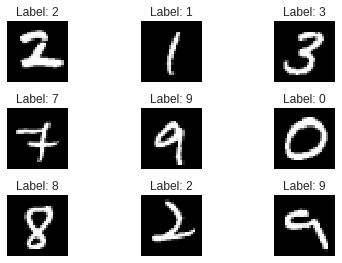

In [8]:
fig = plt.figure()
for i, ind in enumerate(indices):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(x_train[ind].reshape((28,28)), cmap='gray', interpolation='none')
  plt.title("Label: {}".format(y_train[ind]))
  plt.xticks([])
  plt.yticks([])

## Step 3) Build the model

Architecture wise, we'll use a single layer network. All layers are Linear - the classic fully-connected neural network layers.
* The hidden layer will have 512 units using the ReLU activation function.
* The output layer will have 10 units, corresponding to the 10 digits, and use softmax function.

The general convention for Pytorch network classes is that you create all your layers in the constructor, and then lay out their relationship in the forward() method.  


In [0]:
class Net(nn.Module):
    def __init__(self, image_size):
        super(Net, self).__init__()
        self.image_size = image_size
        self.fc1 = nn.Linear(image_size, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.log_softmax(self.fc2(x), dim =1)
        return x


Here you can check what's inside a created model:

In [10]:
model = Net(image_size=28*28)
model

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

The model.parameters() contains our weight and bias matrices:

In [11]:
[p.shape for p in model.parameters()]

[torch.Size([512, 784]),
 torch.Size([512]),
 torch.Size([10, 512]),
 torch.Size([10])]

## Step 4) Training


In [0]:
lr=2e-2

In [0]:
loss_func = nn.CrossEntropyLoss()

Rather then setting up the model optimization in Pytorch, we are going to use fastai's Learner object. (By default, it uses the Adam optimizer.)

In [0]:
learn = Learner(data, Net(image_size=28*28), loss_func=loss_func, metrics=accuracy)


We are going to use learn.fit_one_cycle() because it let us train our network faster.

In [15]:
learn.fit_one_cycle(3, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.214856,0.173976,0.952900,00:04
1,0.099367,0.108278,0.970800,00:04
2,0.037567,0.074677,0.978800,00:04


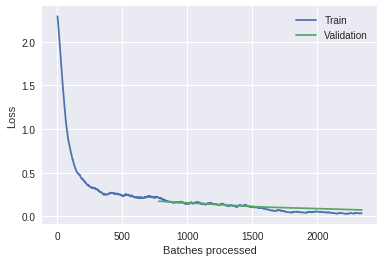

In [16]:
learn.recorder.plot_losses()

If you are interested what learn.fit_one_cycle() does, check the original [Leslie Smith's paper.](https://arxiv.org/abs/1803.09820)

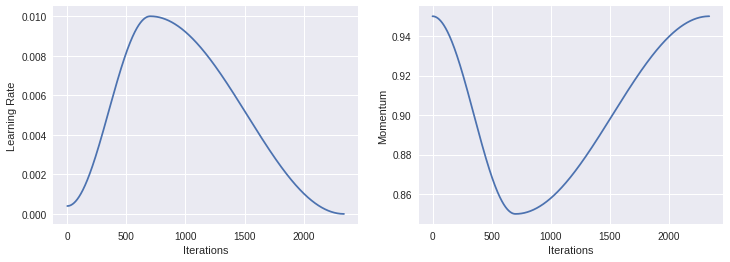

In [17]:
learn.recorder.plot_lr(show_moms=True)